# Hysteresis Processing

## Workflow for hysteresis processing

1) grid the original data by averaging field step size, and interpolate both the upper and lower branches of the hysteresis loop to the same field steps.
2) perform a linear fit on the original loop data for the high field slope (typically > 80% max field values and < 97% max field value) and subtract the linear fit from all the gridded data points. 
 perform paramagnetic/diamagnetic slope correction on the gridded data. Here we use both the upper and lower branches of the hysteresis loops and invert data points in the third quadrant to the first quadrant for line fitting (ordinary least squares) to estimate the paramagnetic/diamagnetic slope.
 
3) perform linearity test on the girdded original data (high field slope correction not applied)

4) at the same time, centering the high-field slope corrected data, and estiamte the optimal values for field and moment offsets.
 Note that when iterating through different H_offset values on the inverted lower branch, the upper and lower branches will have a H field range mismatch. To account for this, in this code we just use the overlapping region for interpolation and ANOVA statistic.

 Testing with synthetic data shows that the exact offset results from this code is slightly different from that of the IRM database. But the results from this function `hyst_loop_centering` are self-consistent (add synthetic offset + or - results in the same corrected R^2 while the IRM function does not). Given that both functions finds the correct offset values, I use the new function

5) calcualte the Q value to represent the signal/noise ratio (data quality) of the whole loop (ferromagnetic component + paramagnetic (also + diamagnetic component)) after centering. 
6) re-grid the original data with applying the estimated optimal values for field and moment offsets.
7) calcualte H and M errors for each data point.
8) calculate mrh, E_hys, Brh, Bih
9) use the sum of M errors to estimate signal drift correction
10) test saturation of the loop by calculating the FN60, 70, 80 statistics and determine where the loop start to saturate.
11) re-apply high field slope correction to the drift-corrected data
12) calculate the Qf value using the drift-corrected, high-field slope corrected data for the ferromagnetic component quanlity estiamtion.
13) calculate Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc


## Install and import packages

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
from scipy.optimize import minimize, brent
from scipy.optimize import least_squares

from numpy.linalg import svd, lstsq
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

We can take the same approach as in the `rockmag_data_unpack.ipynb` notebook to bring the MagIC data into the notebook as a Contribution. 

To bring in a different contribution than the one shown in this example:
-  set the directory path (currently `'./example_data/hyst'`)
-  set the `magic_id` (19216 for  *Swanson-Hysell et al., 2021*)
-  if the contribution is private, set the share key for your MagIC contribution which you can find by clicking on the "Share" button in the MagIC database.

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/MagIC_private_contribution_1.png" alt="Description of the image" width="800">
</figure>

Copy the share key highlighted in grey in the following image to the `share_key` parameter in the cell below.

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/MagIC_private_contribution_2.png" alt="Description of the image" width="800">
</figure>

## Load local data
In this demonstration we will be using local data.

The data is from the following publication:
- Swanson-Hysell, N. L., Avery, M. S., Zhang, Y., Hodgin, E. B., Sherwood, R. J., Apen, F. E., et al. (2021). The paleogeography of Laurentia in its early years: New constraints from the Paleoproterozoic East-Central Minnesota Batholith. Tectonics, 40, e2021TC006751. https://doi.org/10.1029/2021TC006751

In [2]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('ECMB 2018.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

working on:  'contribution\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/contribution.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/contribution.txt
working on:  'specimens\r'
15  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
working on:  'samples\r'
5  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
working on:  'sites\r'
5  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
working on:  'locations\r'
10  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/ex

## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

## Inspect the original data

In [3]:
# plot the hysteresis loop (only looking for 'LP-HYS')
specimen = rmag.make_hyst_plots(measurements)

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED4-1c', 'NED6-6c'), value='NED…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

Output()

## Loop processing

We aim to offer the ability to calculate the hysteresis loop parameters as available in the IRMDB software, with the goal of being able to export the statistics into the MagIC specimen data table. 

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/IRM_hyst_processing_screenshot.png" alt="Description of the image" width="800">
</figure>

The automated processing function will follow the workflow presented in Paterson et al., 2018

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/hyst_loo_processing_workflow.png" alt="Description of the image" width="500">
</figure>


### select specimen hysteresis data

In [4]:
# extract the specimen specific data, for this demonstration, we use specimen NED18-2c
hyst_data = rmag.extract_hysteresis_data(measurements, 'NED1-5c')

loop_fields = hyst_data['meas_field_dc']
loop_magnetizations = hyst_data['magn_mass']

### execute default hysteresis processing procedure following the flowchart above

raw data is not linear
FNL:  10478.66
loop centering results: field offset = 0.0 T magnetization offset = 0.0006 Am^2/kg
centered loop Q value: 3.19
apply default high field linear correction: slope (X_para/dia) = 0.1647 intercept (Ms) = 0.0339 Am^2/kg
SNR = -89.3 dB
HAR = -40.97 dB
loop is open!
loop is saturated beyond 600.6 mT


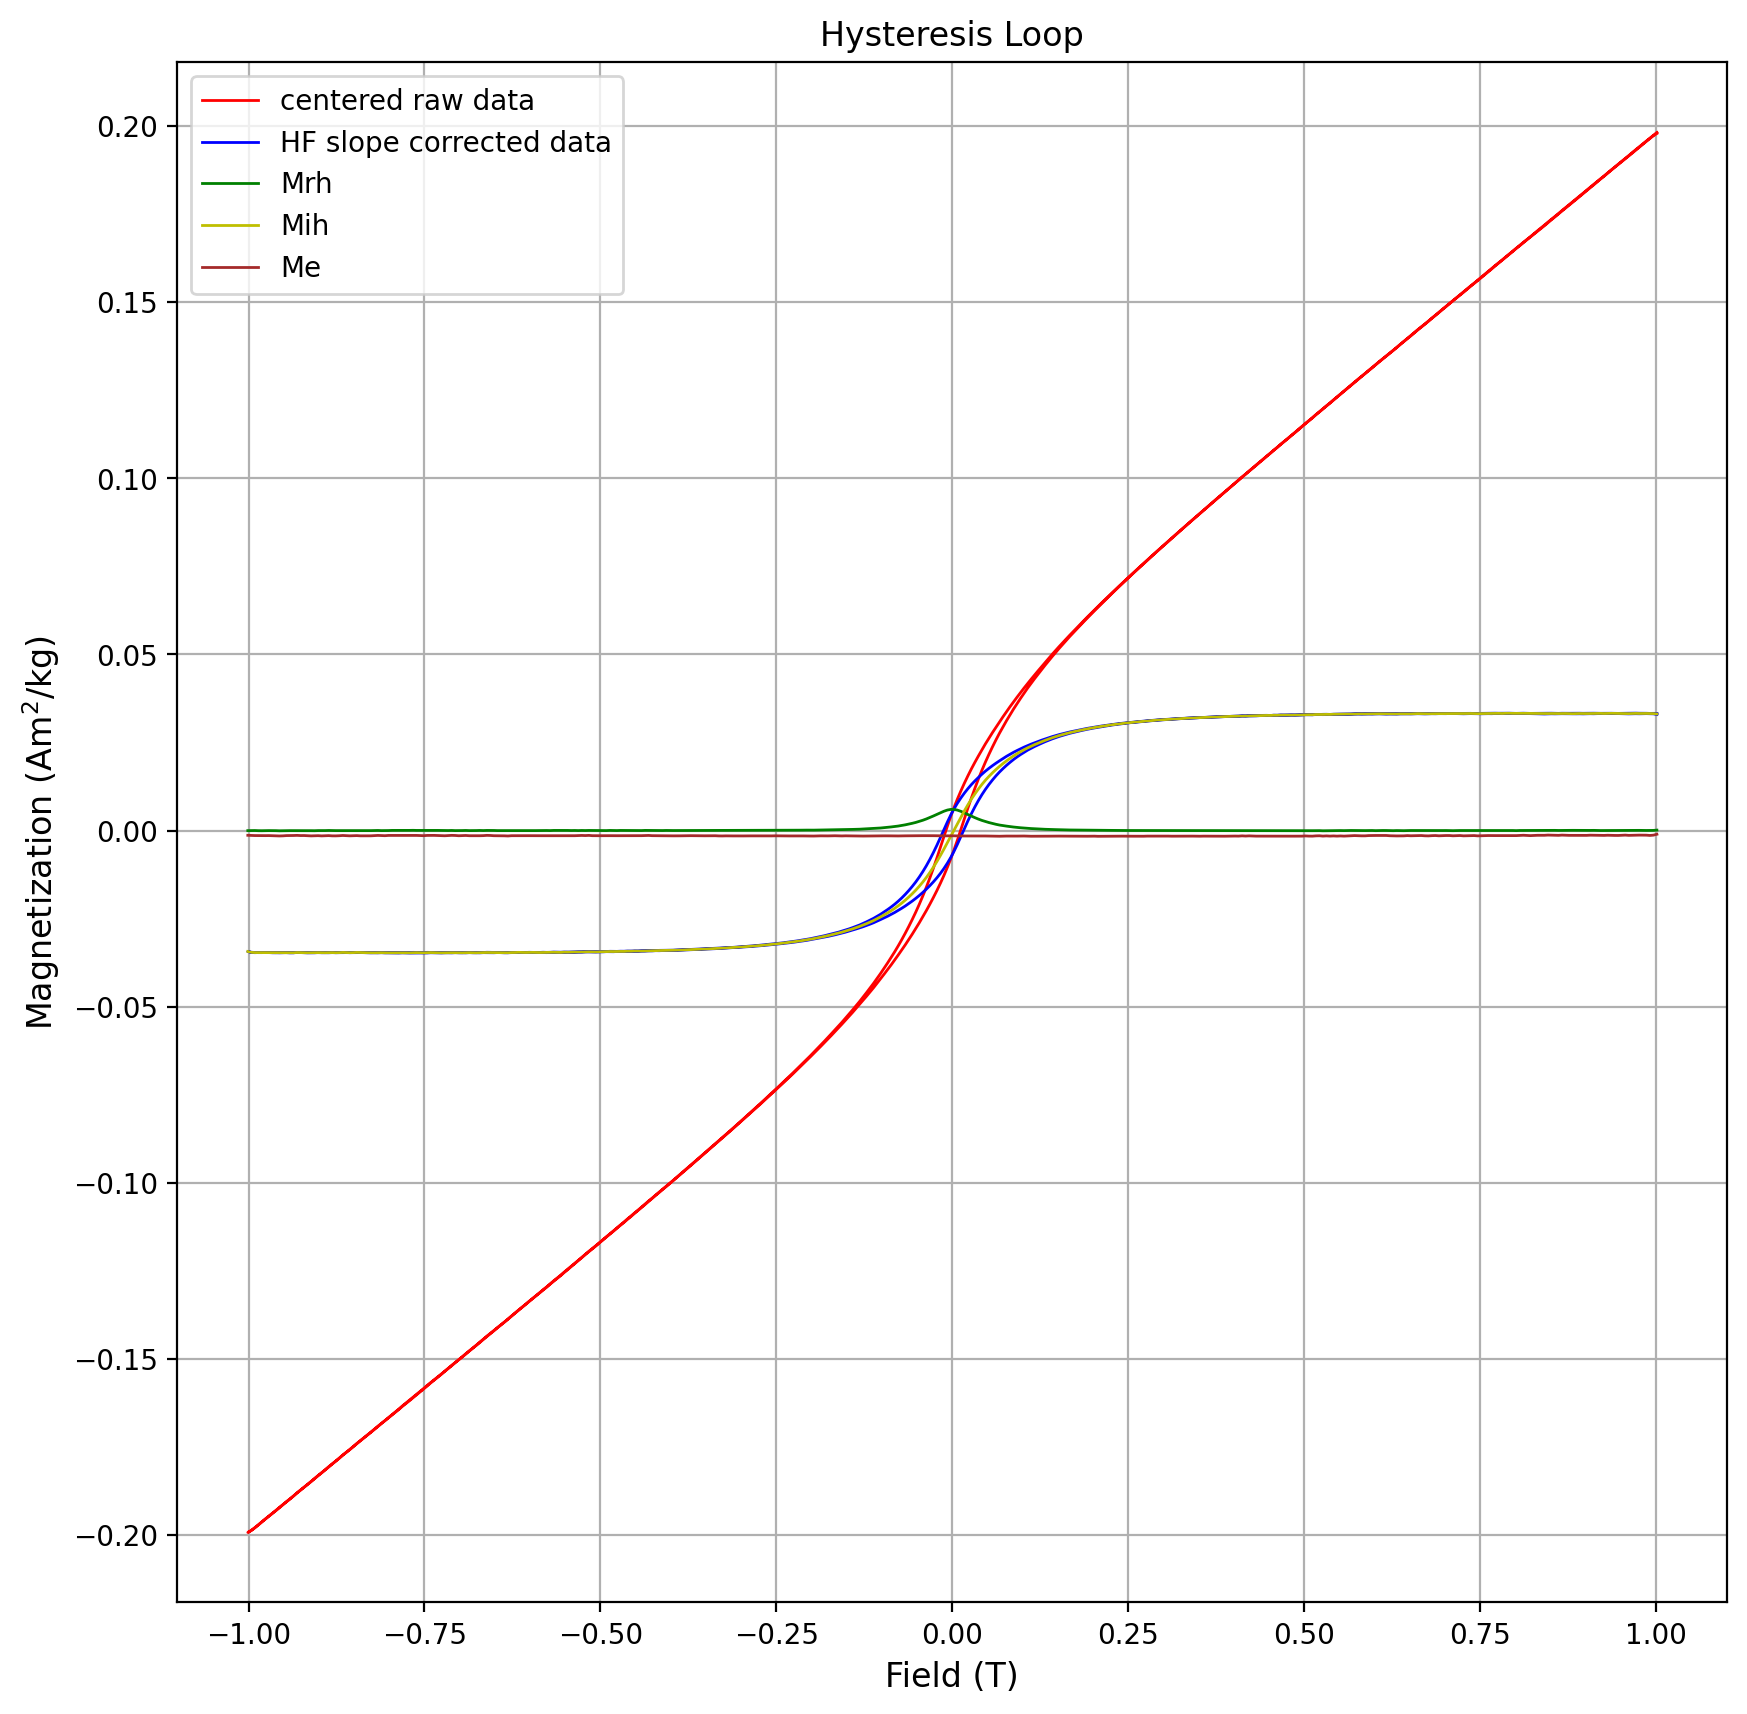

In [24]:
results, ax = process_hyst_loop(loop_fields, loop_magnetizations)

### inspect the loop processing stats

In [6]:
results['loop_centering_results']

{'opt_H_offset': 0.0,
 'opt_M_offset': 0.0006706780851330234,
 'R_squared': 0.9999971889892862,
 'M_sn': 596.4427302801345,
 'Q': 2.7755687495698718}

In [7]:
results['loop_saturation_stats']

{'FNL60': 86.44996220281047,
 'FNL70': 65.09077978574224,
 'FNL80': 47.38282395967419,
 'saturation_cutoff': 0.92}

## Manually apply loop drift correction

- in the example of NED18-2c above, the loop drift is present (subtle, but significant such that the upper and lower branches of the loop do not overlap toward 1T). 
- We can see in the IRM software such drift is not automatically corrected for. It is upon user's discretion to apply drift corrections. 
- Below we will walk through the drift correction process as described in Jackson and Solheid, 2010. 

### positive field correction

- One type of drift correction is to apply a prorated drift correction based on the value of Mce which is the difference between measured magnetizations at the highest positive fields applied during the upper and lower branches. 

In [26]:
grid_example_magnetizations_centered_HF_drift_corr = prorated_drift_correction(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr)

{'FNL60': 86.44996220294112, 'FNL70': 65.09077978572896, 'FNL80': 47.382823959654054, 'saturation_cutoff': 0.92}


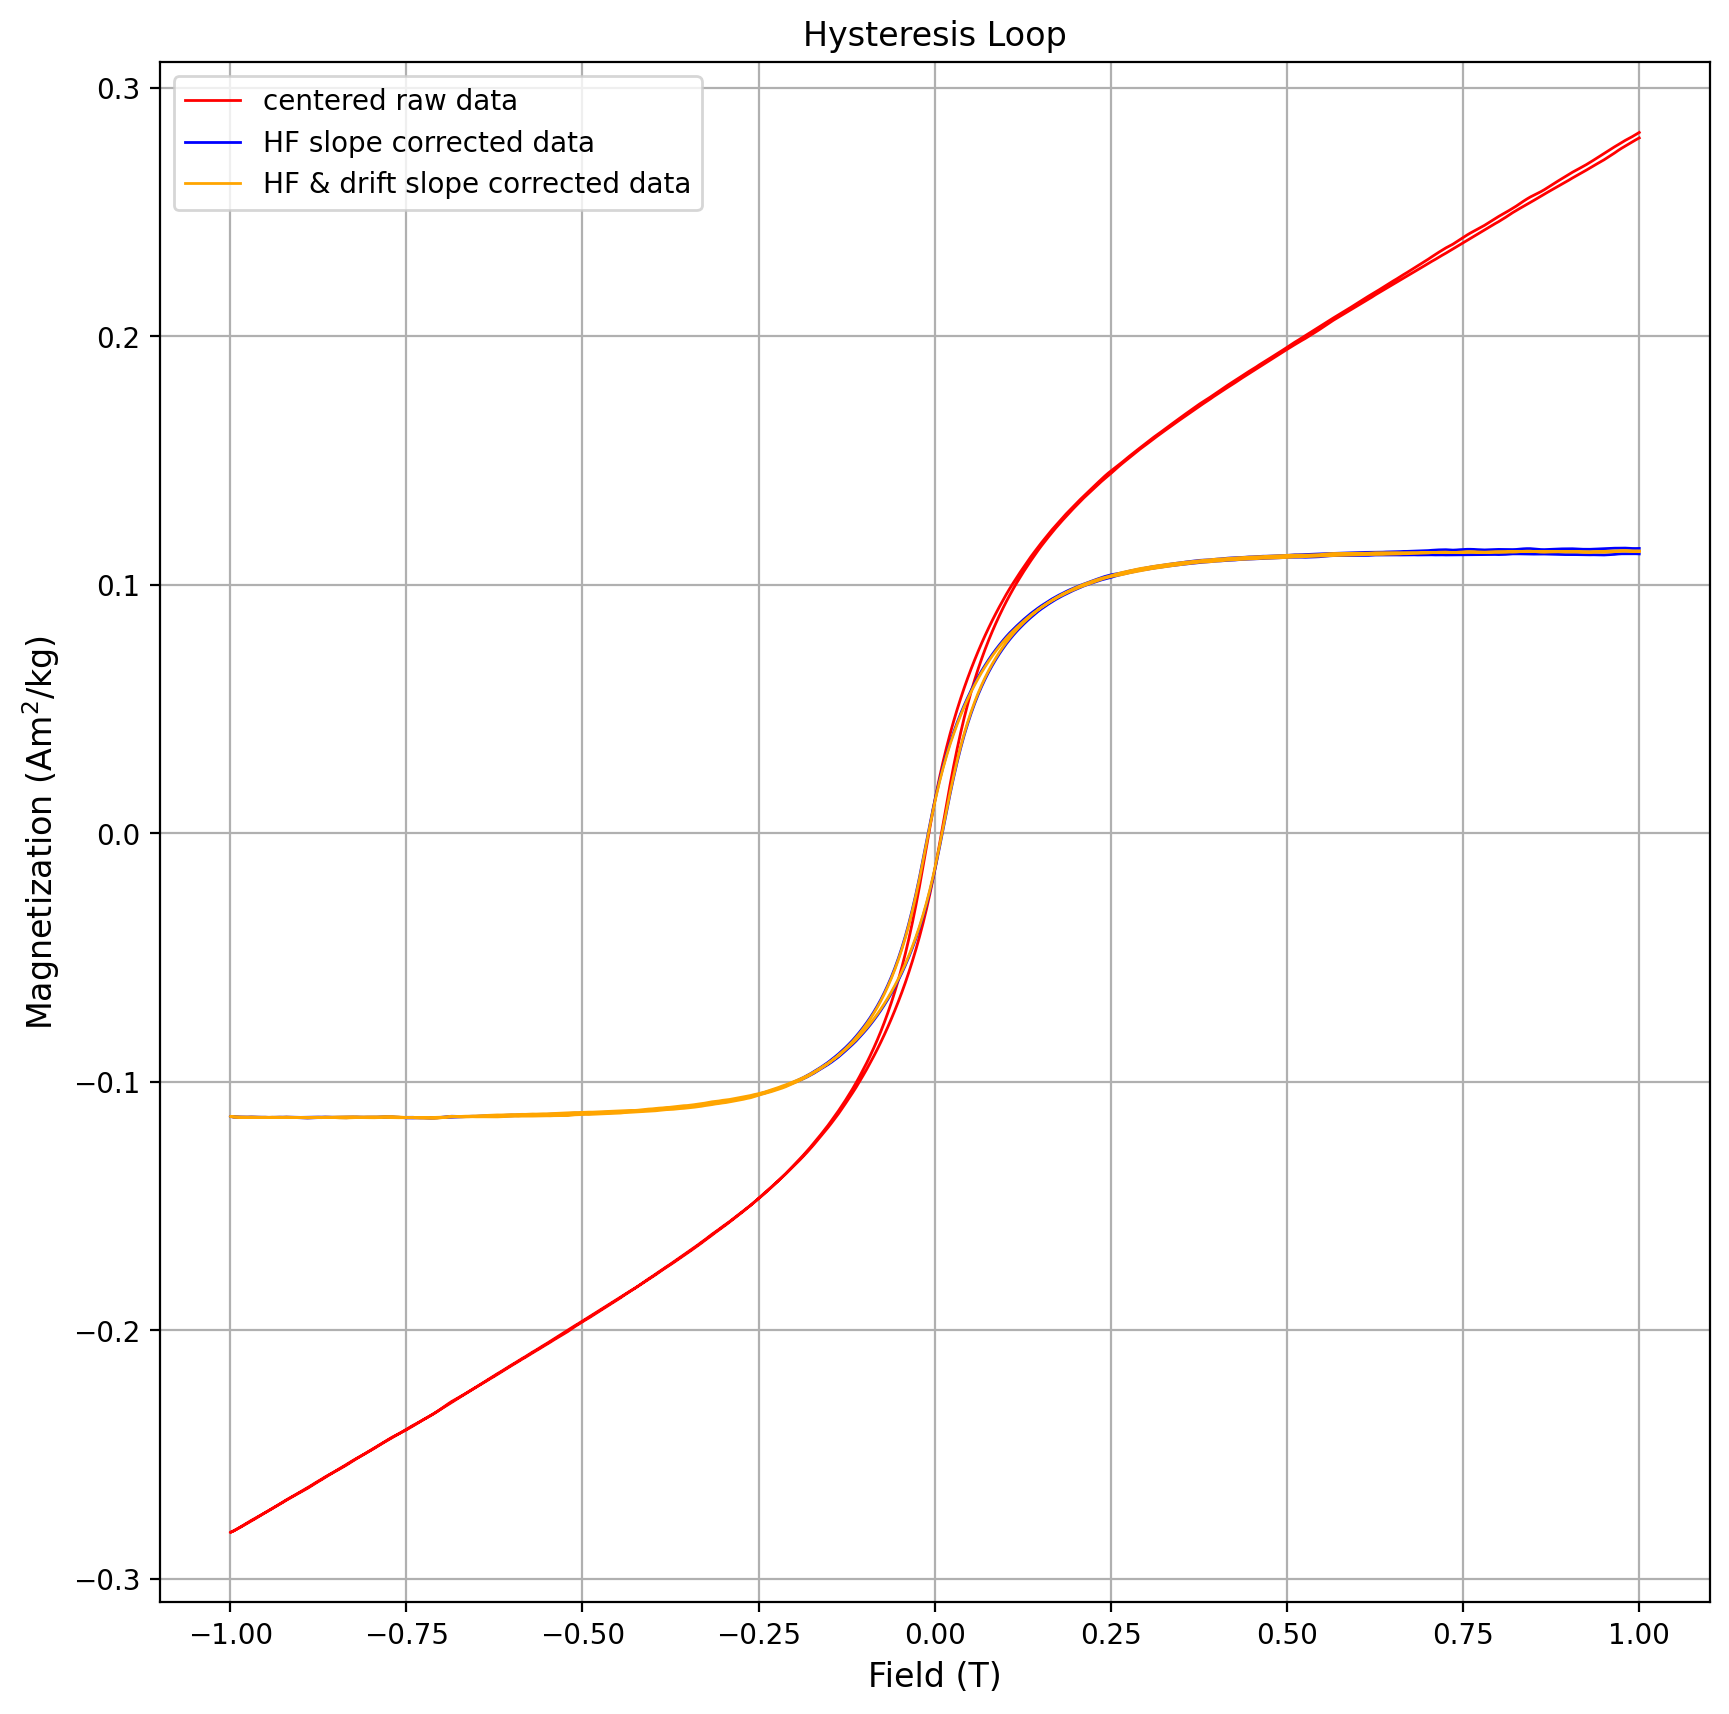

In [27]:
fig, ax =  plt.subplots(figsize=(10,10))
ax = plot_hysteresis_loop(ax, grid_example_fields_centered, grid_example_magnetizations_centered, 
                          color='r', linewidth=1, label='centered raw data')
ax.plot(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr, 
        color='b', linewidth=1, label='HF slope corrected data')
ax.plot(grid_example_fields_centered, grid_example_magnetizations_centered_HF_drift_corr, 
        color='orange', linewidth=1, label='HF & drift slope corrected data')

print(hyst_loop_saturation_test(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr))
# plt.xlim(0.8, 1)
# plt.ylim(0.09, 0.11)
plt.legend()
plt.show()

### upper branch correction
- The upper branch correction subtracts the smoothed noise curve from the upper branch of the hysteresis loop (Jackson & Solheid, 2010)

In [30]:
upper_branch_drift_corr = upper_brach_drift_correction(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr)

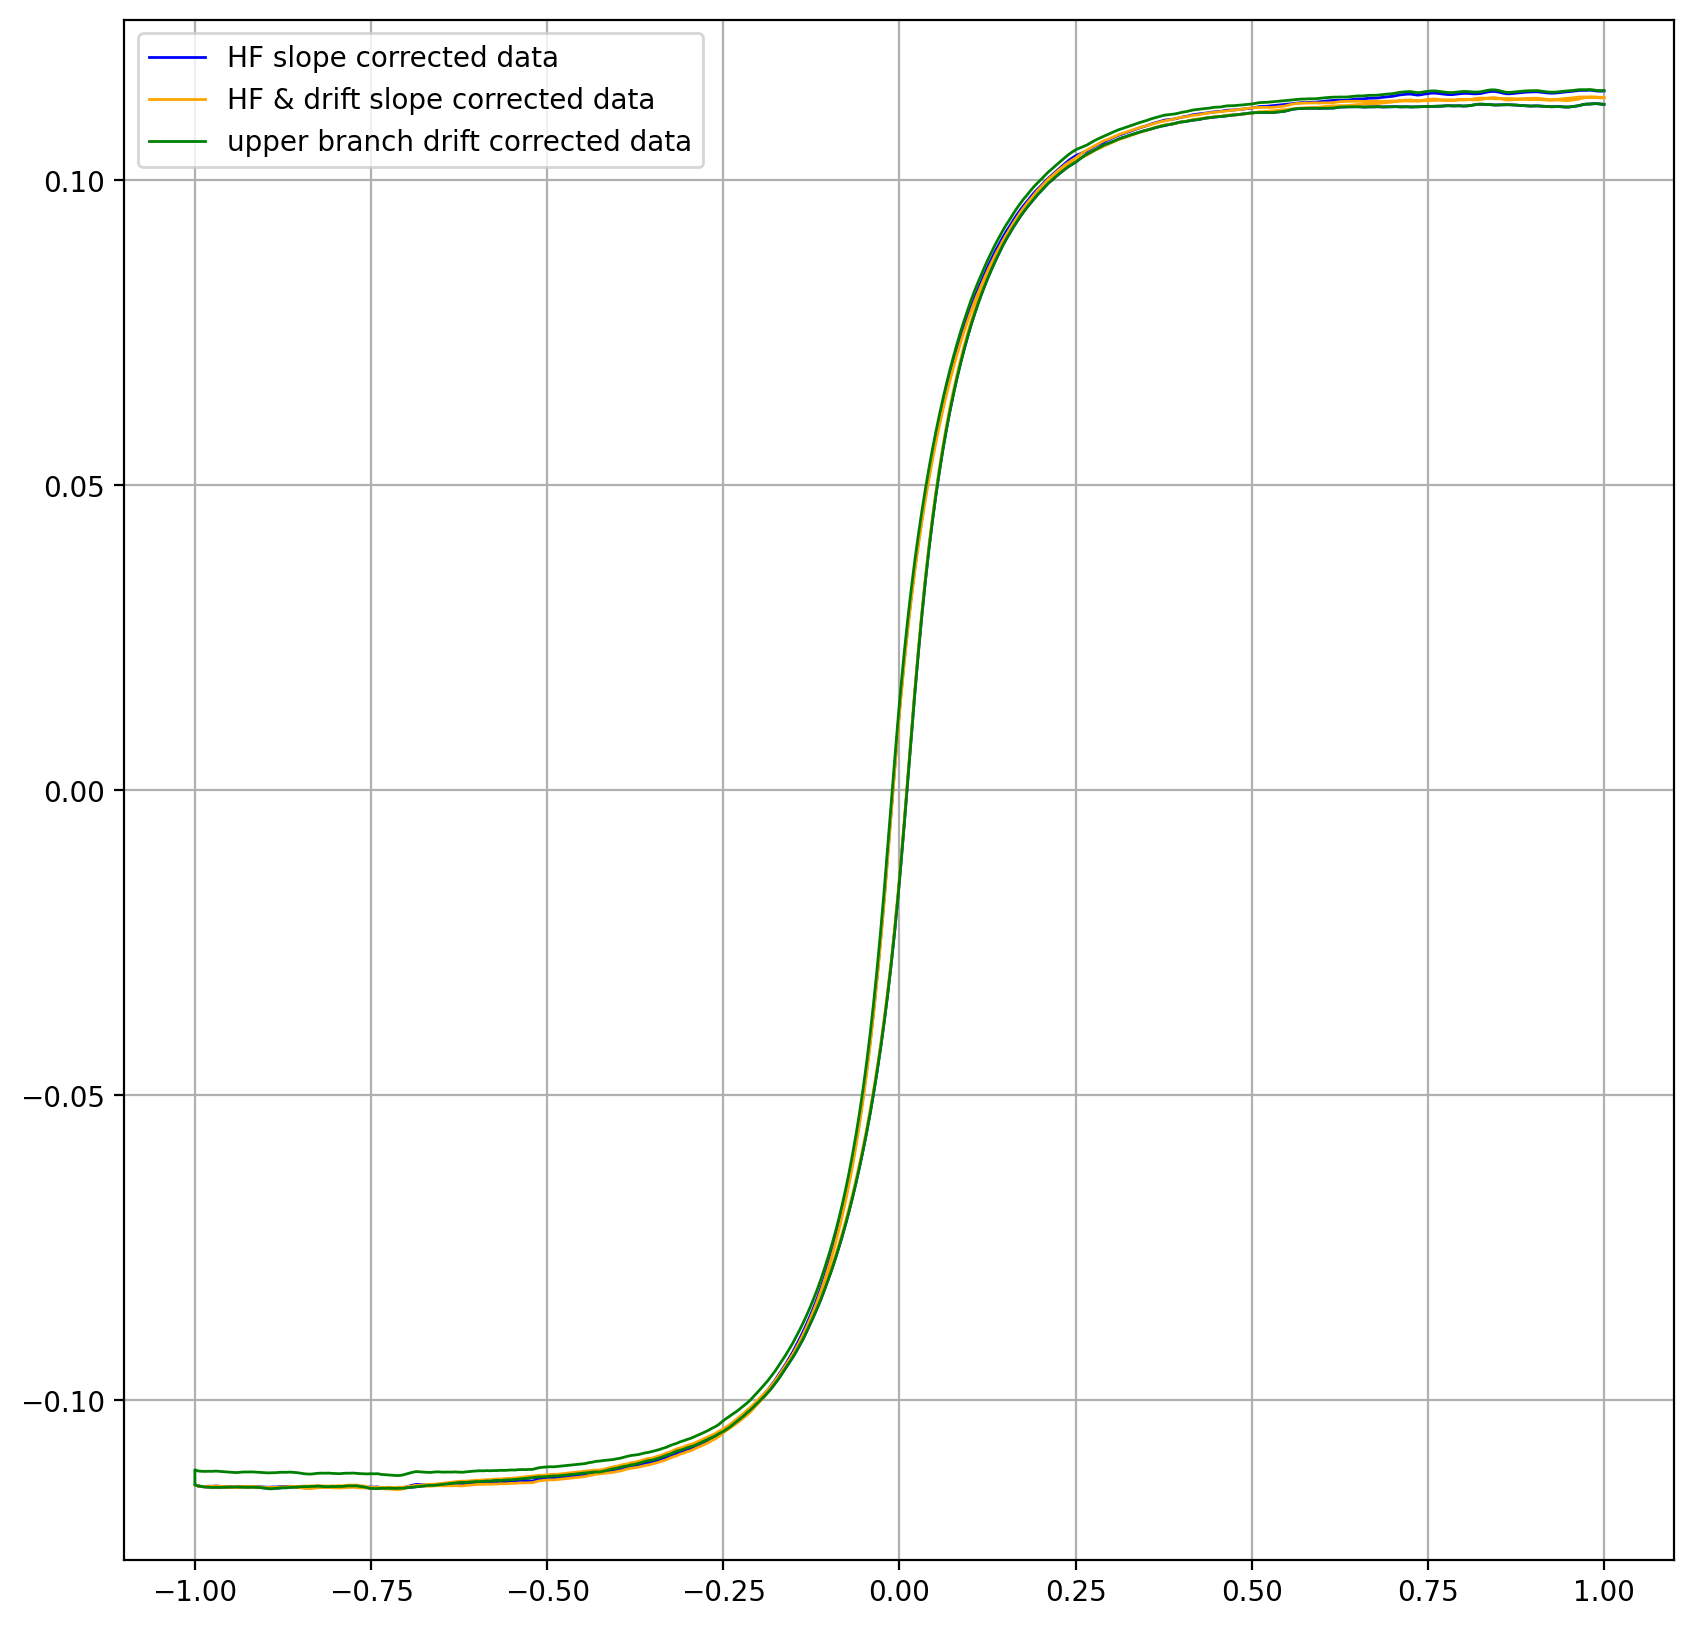

In [31]:
fig, ax =  plt.subplots(figsize=(10,10))
# ax = plot_hysteresis_loop(ax, grid_example_fields_centered, grid_example_magnetizations_centered, 
#                           color='r', linewidth=1, label='centered raw data')
ax.plot(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr, 
        color='b', linewidth=1, label='HF slope corrected data')
ax.plot(grid_example_fields_centered, grid_example_magnetizations_centered_HF_drift_corr, 
        color='orange', linewidth=1, label='HF & drift slope corrected data')
ax.plot(grid_example_fields_centered, upper_branch_drift_corr,
        color='g', linewidth=1, label='upper branch drift corrected data')
ax.grid()
# plt.xlim(0.8, 1)
# plt.ylim(0.09, 0.11)
plt.legend()
plt.show()

### Symmetric averaging

- Symmetric averaging follows von Dobeneck (1996), whereby the upper and inverted lower branches are averaged and vertically shifted by half their tip-to-tip separation to ensure loop closure.
- In this demo case, symmetric average does not work well.

In [33]:
symmetric_averaging_drift_corr = symmetric_averaging_drift_corr(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr)

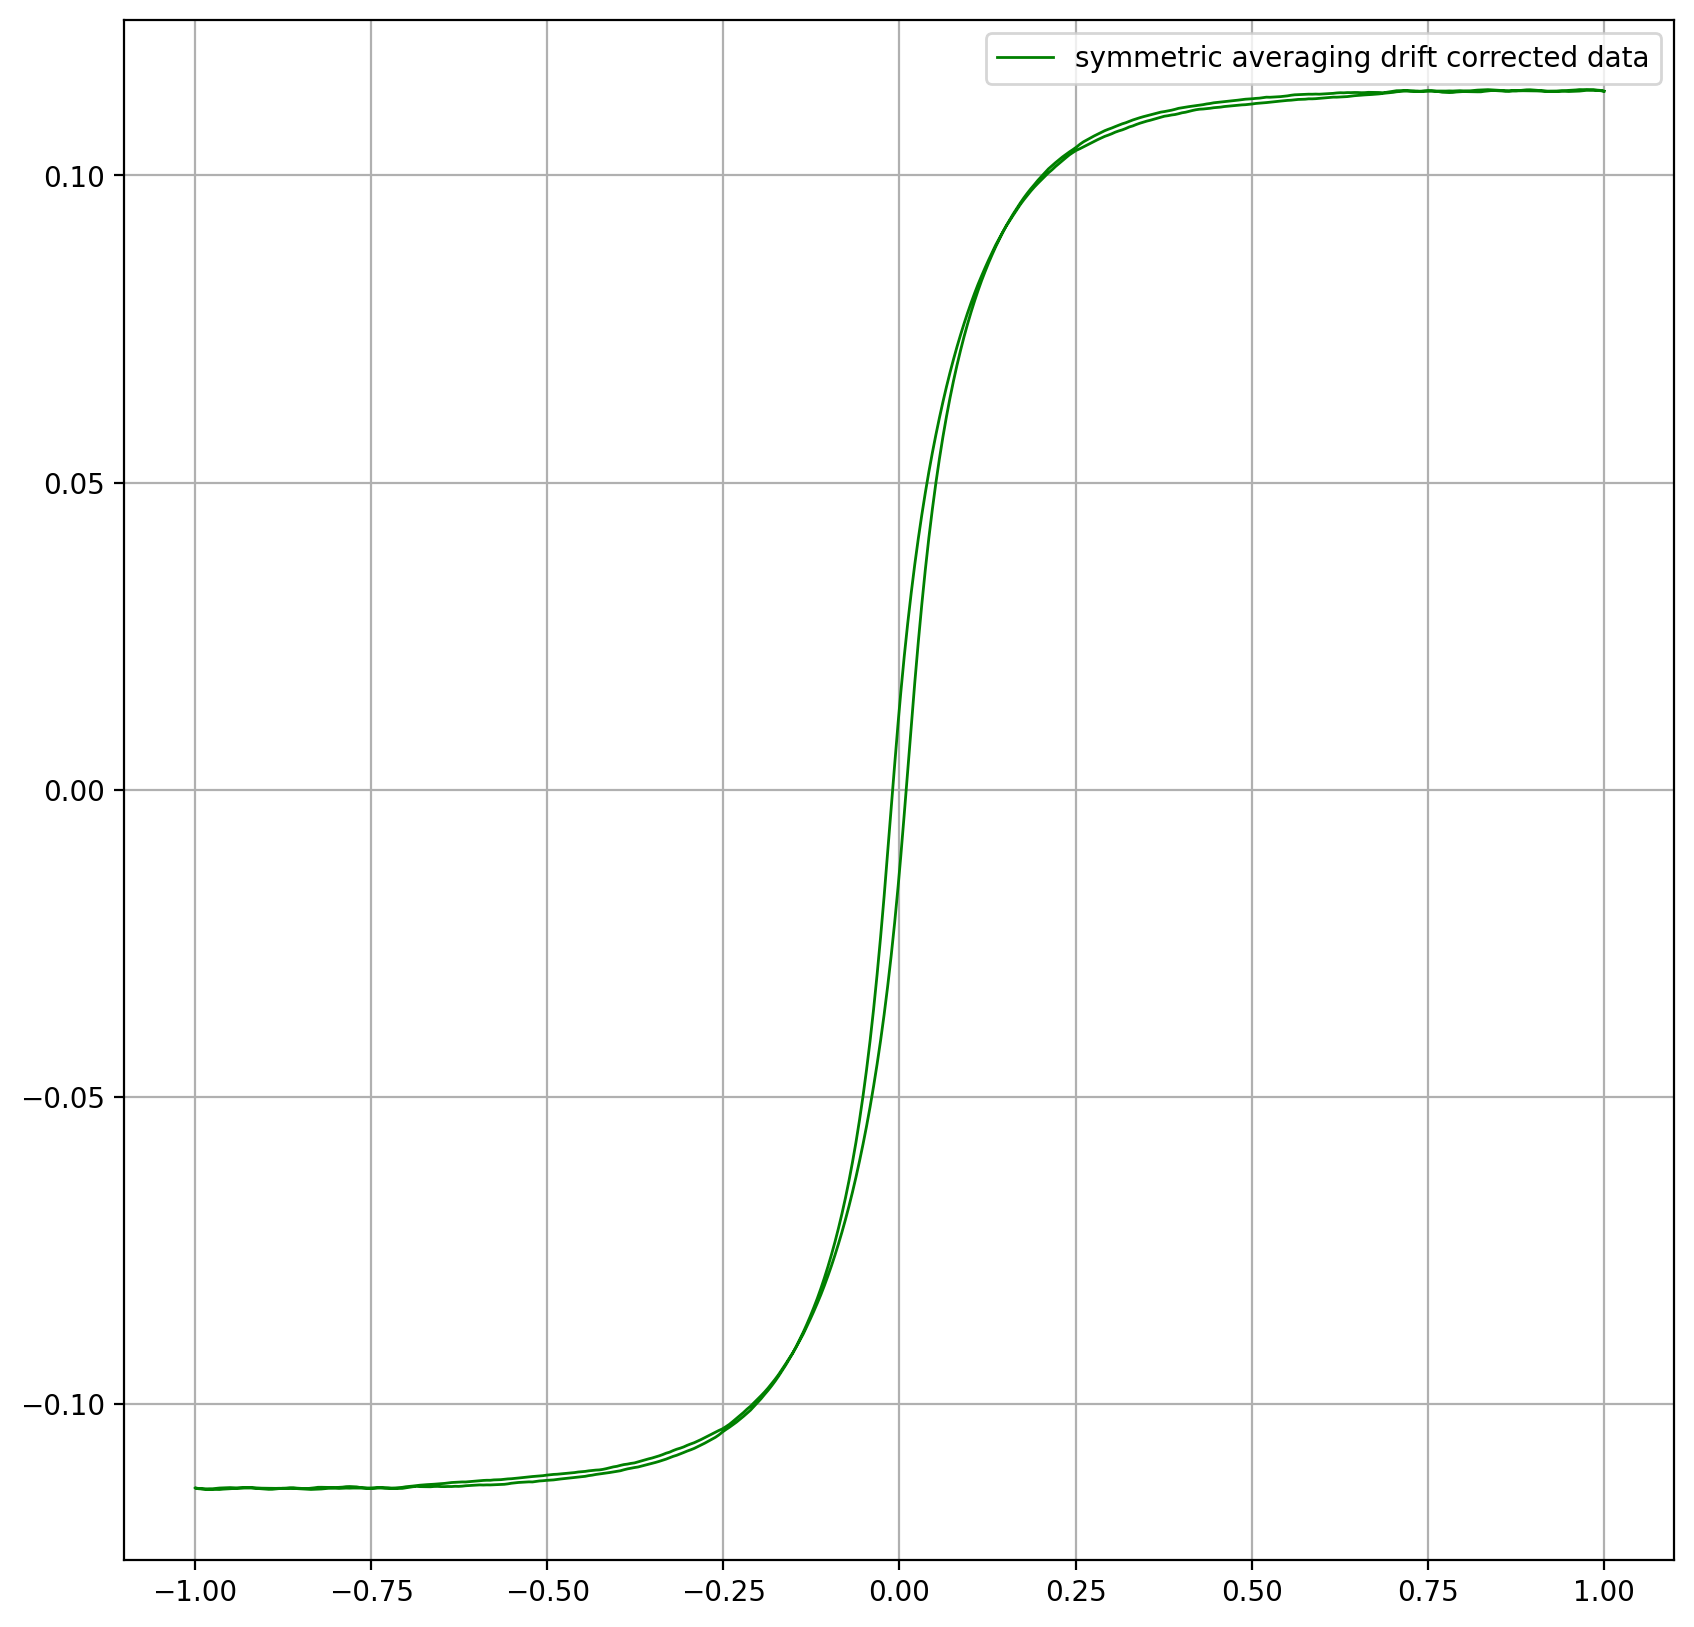

In [ ]:
fig, ax =  plt.subplots(figsize=(10,10))

ax.plot(grid_example_fields_centered, symmetric_averaging_drift_corr,
        color='g', linewidth=1, label='symmetric averaging drift corrected data')
ax.grid()
# plt.xlim(0.8, 1)
# plt.ylim(0.09, 0.11)
plt.legend()
plt.show()